<a href="https://colab.research.google.com/github/ymiftah/energysys/blob/main/Economic_Dispatch_of_Thermal_Units.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites



In [ ]:
!rm -r energysys
!git clone https://github.com/ymiftah/energysys.git
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install -q pyomo

Cloning into 'energysys'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 105 (delta 51), reused 89 (delta 35), pack-reused 0
Receiving objects: 100% (105/105), 5.96 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from energysys.systems.thermal import ThermalUnit
from energysys.systems.core import System

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Economic Dispatch of Thermal Units and Methods of Solution

The dispatch of thermal units is a standard problem in power systems management

The units characteristics are given as :

| Input-Output Curves &nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| Minimum (MW) | Maximum (MW) | Fuel Cost (\$/MBtu) |
| ------------- | :----: | :----: | :----: |
|$H_1 = 225 + 8.4 P_1 + .0025 P_1^2$ | 45 | 350 | 0.80 |
|$H_2 = 729 + 12.3 P_2 + .0015 P_2^2$ | 45 | 350 | 1.02 |
|$H_3 = 400 + 7.5 P_3 + .0021 P_3^2$ | 47.5 | 450 | 0.9 |

where :

$$
H_n = \text{fuel input to unit } n \text{ in MBtu per hour} \\
P_n = \text{unit output in megawatts}
$$




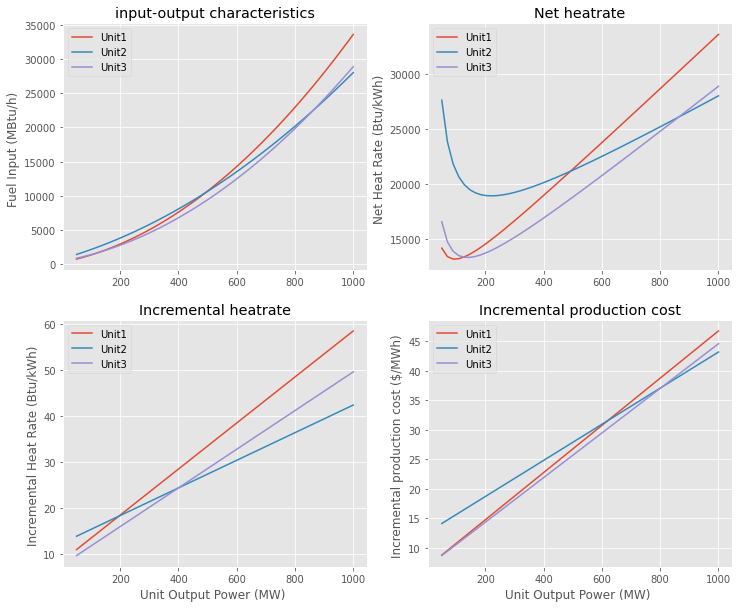

In [ ]:
#@title Unit Characteristics
P = np.linspace(50, 1000, 50)

sys = System(
        (ThermalUnit("Unit1", [225,  8.4, .025],   .8, min_power=45, max_power=350),
         ThermalUnit("Unit2", [729, 12.3, .015], 1.02, min_power=45, max_power=350),
         ThermalUnit("Unit3", [400,  7.5, .021],   .9, min_power=50, max_power=450))
        )

fig = plt.figure(figsize=(12,10))

# Input-Output
plt.subplot(2,2,1)
for u in sys:
    plt.plot(P, u.input_output(P))
plt.legend([u.name for u in sys])
plt.title("input-output characteristics")
plt.ylabel("Fuel Input (MBtu/h) ")

# Net Heat rate
plt.subplot(2,2,2)
for u in sys:
    plt.plot(P, u.net_heatrate(P))
plt.legend([u.name for u in sys])
plt.title("Net heatrate")
plt.ylabel("Net Heat Rate (Btu/kWh) ")

# Incremental Heat rate
plt.subplot(2,2,3)
for u in sys:
    plt.plot(P, u.marginal_heatrate(P))
plt.legend([u.name for u in sys])
plt.title("Incremental heatrate")
plt.xlabel("Unit Output Power (MW) ")
plt.ylabel("Incremental Heat Rate (Btu/kWh) ")

# Incremental Production cost
plt.subplot(2,2,4)
for u in sys:
    plt.plot(P, u.marginal_cost(P))
plt.legend([u.name for u in sys])
plt.title("Incremental production cost")
plt.xlabel("Unit Output Power (MW) ")
plt.ylabel("Incremental production cost ($/MWh) ")
plt.show()

The economic dispatch can be framed as an optimisation problem:

$$
\min_{P_1,P_2, P_3} c_1 H_1(P_1) + c_2 H_2(P_2) + c_3 H_3(P_3)\\
\text{s.t.  } P_1 + P_2 + P_3 = D 
$$

Where D is the load. Here **we ignore for now the minimum and maximum power of each unit**. We will see further below how to treat them.

The analytical solution of this problem can be obtained by introducing the lagrangian of the problem :

$$
\mathcal{L}(P_1, P_2, P_3, \lambda) = c_1H_1(P_1) + c_2H_2(P_2) + c_3H_3(P_3) - \lambda(P_1 + P_2 + P_3- D)
$$

And solving the below equations for $P_1, P_2, \lambda$ :

$$
\frac{\partial \mathcal{L}}{\partial P_1} = 0, \  
\frac{\partial \mathcal{L}}{\partial P_2} = 0, \
\frac{\partial \mathcal{L}}{\partial P_3} = 0, \
\frac{\partial \mathcal{L}}{\partial \lambda} = 0
$$

Which translates into:

$$
c_1\frac{dH_1}{d P_1} = \lambda, \\  
c_2\frac{dH_2}{d P_2} = \lambda, \\  
c_3\frac{dH_3}{d P_3} = \lambda, \\  
P_1 + P_2 + P_3 = D
$$

We can solve the system (3 independent* equations, 3 unkowns) to obtain the values of $P_1$, $P_2$ and $\lambda$ that minimize the total cost.

We observe that dimension of $\lambda$  is one of a price per unit of energy (\$/MWh). It is the marginal cost of production of the units, and at the optimum it is equal for both units.

This reframes a qualitative analysis we could have made on economic principles: if the marginal costs were not equal, then we could have made further saving by decreasing the output of the unit with higher marginal costs, and increasing the output of the one with lower maringal costs. Thus at the optimal dispatch, the marginal costs of each unit must be equal.

This analysis tells us that we could also have obtained the solution graphically by finding the optimal marginal cost $\lambda_{opt}$ for which the units total output equals the load in the system

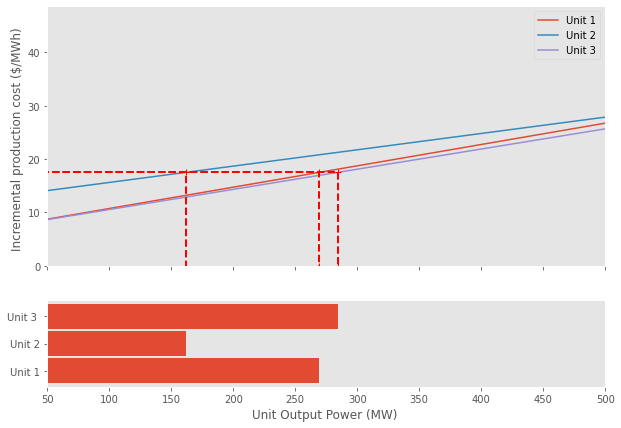

In [ ]:
#@title Economic Dispatch { run: "auto" }

demand = 715 #@param {type:"slider", min:500, max:1000}
coefs = np.array([
         [225, 8.4, .025],
         [729, 12.3, .015],
         [400, 7.5, .021]
])
c = [.8, 1.02, .9]
A = np.array([
              [1, 1, 1, 0],
              [coefs[0][2]*2, 0, 0, -1/c[0]],
              [0, coefs[1][2]*2, 0, -1/c[1]],
              [0, 0, coefs[2][2]*2, -1/c[2]]
])
b = np.array([demand, *(-coefs[:,1])])
p1, p2, p3, marg = np.linalg.solve(A,b)

# Bar PLot
labels = ["Unit 1", "Unit 2", "Unit 3"]
power_gen = [p1, p2, p3]
width = 0.9       # the width of the bars: can also be len(x) sequence


f, (a0, a1) = plt.subplots(2, 1, figsize=(10, 7),
                           sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]})

# Incremental Production cost
for u in sys:
    a0.plot(P, u.marginal_cost(P))
a0.legend(["Unit 1", "Unit 2", "Unit 3"])
a0.set_ylabel("Incremental production cost ($/MWh) ")
a0.set_ylim(0,None)
a0.grid()
a0.plot((0, p1, p1), (marg, marg, 0), 'r+--', linewidth=2)
a0.plot((0, p2, p2), (marg, marg, 0), 'r+--', linewidth=2)
a0.plot((0, p3, p3), (marg, marg, 0), 'r+--', linewidth=2)


a1.barh((2, 1, 0), power_gen, width,
        align='center',
        #color=['blue', 'orange' ]
        )
a1.yaxis.set_label_position("right")
a1.set_yticklabels(('', 'Unit 3 ','Unit 2', 'Unit 1'))
a1.invert_yaxis()
a1.set_xlim(50, 500)
a1.set_xlabel("Unit Output Power (MW) ")
a1.grid()


plt.show()

### Lambda Iteration

In the above section we have ignored power limits. We can come up with a method to find the optimal dispatch by searching for the marginal cost at the optimum.
1. If all units are operating between their limits, the optimal dispatch is the one that equals the marginal cost for all units.
2. If a unit reaches its upper (lower) bound, the marginal cost at optimum can be higher (lower) than the unit marginal cost at its bound.

We can proceed by dichotomy to find to right value of $\lambda$

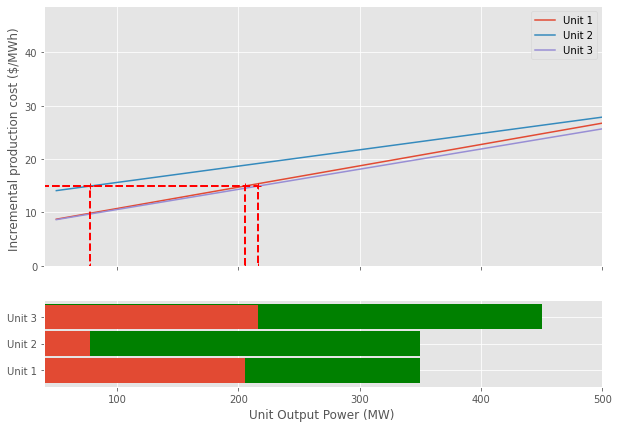

In [ ]:
from energysys.solvers.economic_dispatch import LambdaIteration
#@title Lambda Iteraion { run: "auto" }

demand = 500 #@param {type:"slider", min:500, max:1000}

solver = LambdaIteration()
power_gen = solver.solve(sys, demand)
p1, p2, p3 = power_gen
marg = solver.lambda_value

# Bar PLot
labels = ["Unit 1", "Unit 2", "Unit 3"]

f, (a0, a1) = plt.subplots(2, 1, figsize=(10, 7),
                           sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]})

# Incremental Production cost
for u in sys:
    a0.plot(P, u.marginal_cost(P))
a0.legend(labels)
a0.set_ylabel("Incremental production cost ($/MWh) ")
a0.set_ylim(0,None)
for p in power_gen:
    a0.plot((0, p, p), (marg, marg, 0), 'r+--', linewidth=2)


a1.barh((2, 1, 0), [u.max_power for u in sys], .92, align='center', color='green')
a1.barh((2, 1, 0), power_gen, .9, align='center')
a1.yaxis.set_label_position("right")
a1.set_yticklabels(('', 'Unit 3','Unit 2', 'Unit 1'))
a1.invert_yaxis()
a1.set_xlim(40, 500)
a1.set_xlabel("Unit Output Power (MW) ")


plt.show()

## Quadratic Programing

We can directly solve the dispatch with a non linear solver. Well performing solvers are readily available to solve quadratic optimisation problems. The scipy library implements a trust region method, which we will take advantage of.

The solver also provides us with the lagrange multiplier of the power balance constraint, which provide us with the marginal cost of production.

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 15, CG iterations: 24, optimality: 2.15e-11, constraint violation: 0.00e+00, execution time: 0.044 s.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


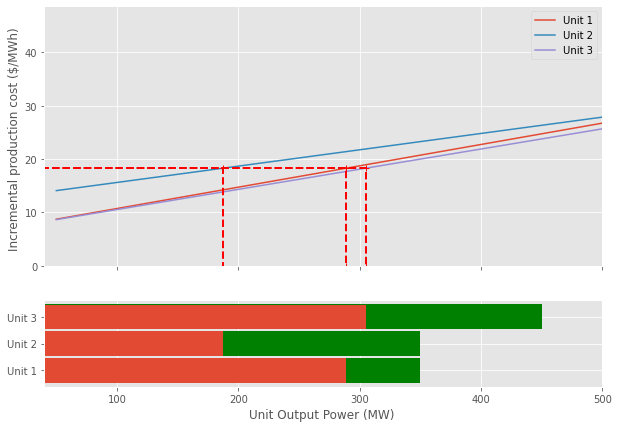

In [ ]:
from energysys.solvers.economic_dispatch import QPScipy
#@title Quadratic programming { run: "auto" }
demand = 782 #@param {type:"slider", min:500, max:1000}

qsp = QPScipy()
qsp.solve(sys, demand)
power_gen = qsp.res.x
p1, p2, p3 = power_gen
marg = - qsp.res.v[0]

# Bar PLot
labels = ["Unit 1", "Unit 2", "Unit 3"]

f, (a0, a1) = plt.subplots(2, 1, figsize=(10, 7),
                           sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]})

# Incremental Production cost
for u in sys:
    a0.plot(P, u.marginal_cost(P))
a0.legend(labels)
a0.set_ylabel("Incremental production cost ($/MWh) ")
a0.set_ylim(0,None)
for p in power_gen:
    a0.plot((0, p, p), (marg, marg, 0), 'r+--', linewidth=2)


a1.barh((2, 1, 0), [u.max_power for u in sys], .92, align='center', color='green')
a1.barh((2, 1, 0), power_gen, .9, align='center')
a1.yaxis.set_label_position("right")
a1.set_yticklabels(('', 'Unit 3','Unit 2', 'Unit 1'))
a1.invert_yaxis()
a1.set_xlim(40, 500)
a1.set_xlabel("Unit Output Power (MW) ")


plt.show()

# Reference

1. Allen J. Wood, Bruce F. Wollenberg, Gerald B. Sheblé - Power Generation, Operation and Control